## Problem 1

In [4]:
using Images
using LinearAlgebra

In [103]:
img_path = "harvey-saturday-goes7am.jpg"
img = load(img_path)
size(img)

(1296, 1548)

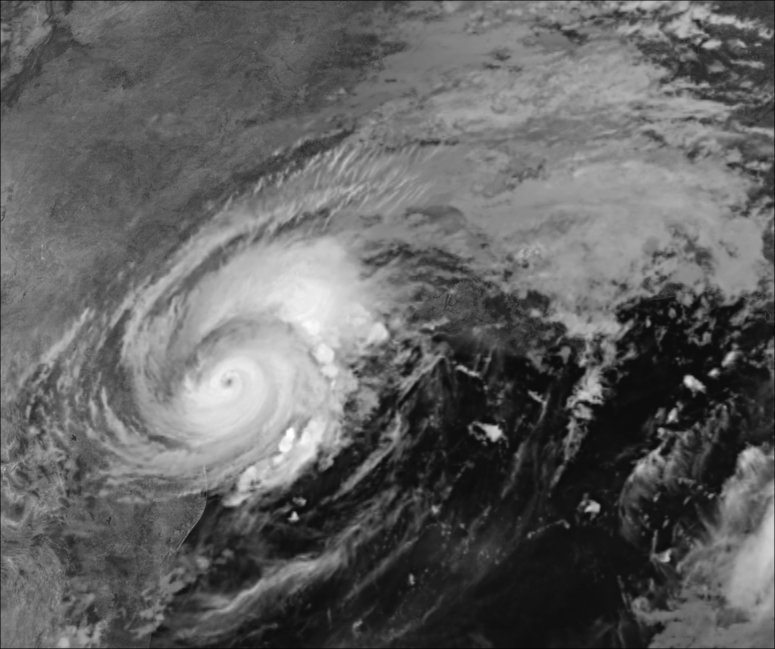

In [19]:
X = Gray.(img)

In [100]:
X = Float64.(X);

In [72]:
function svd_compress(X, k)
    
    U, σ, V = svd(X, full=true); # slow to redo SVD, but not a big deal for homework
    X̃       = sum(σ[i] * U[:, i] * V[:, i]' for i in 1:k)
    err     = norm(X - X̃)/norm(X)
    
    return X̃, err
    
end

svd_compress (generic function with 1 method)

### Problem 1a  |  $k = 2$

0.2815103158754801

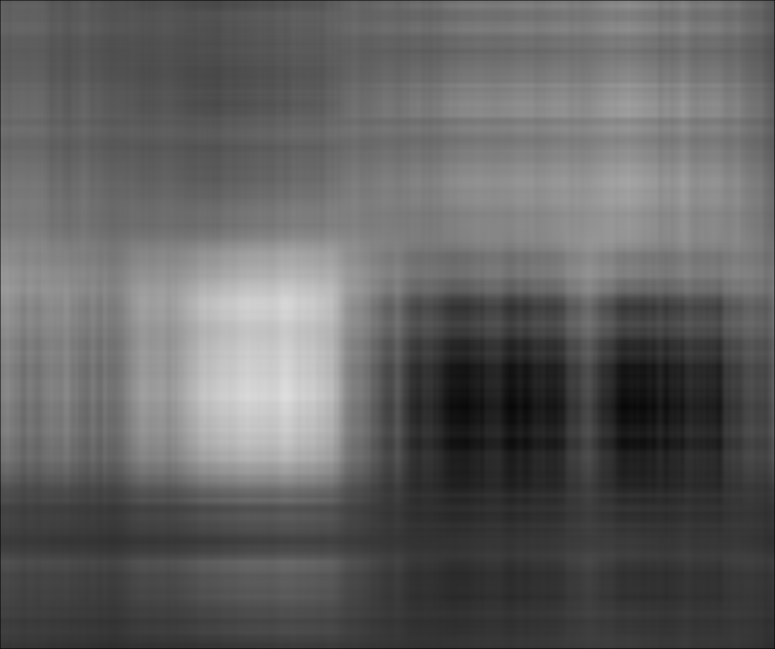

In [73]:
X̃, err = svd_compress(X, 2)
print(err)
Gray.(X̃)

### Problem 1a  |  $k = 10$

0.15876586555633745

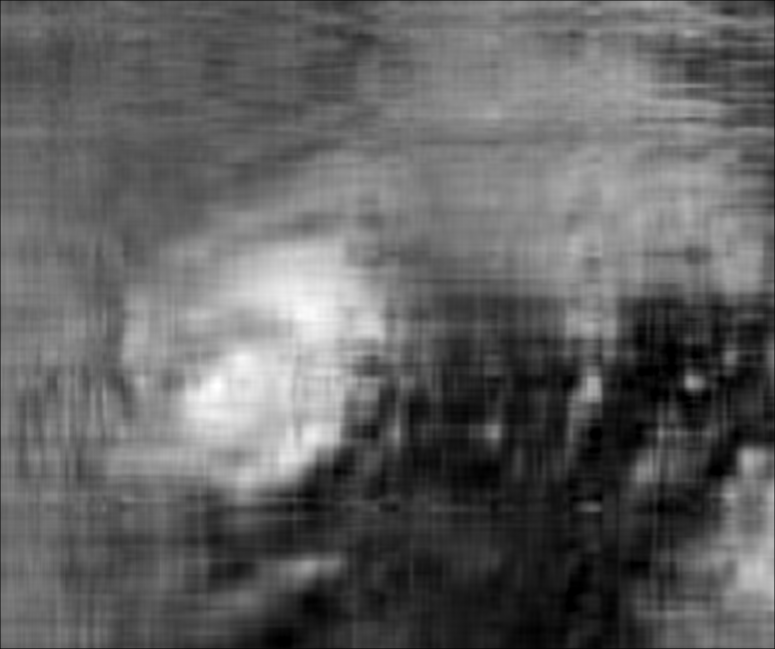

In [74]:
X̃, err = svd_compress(X, 10)
print(err)
Gray.(X̃)

### Problem 1a | $k = 40$

0.08368458635729387

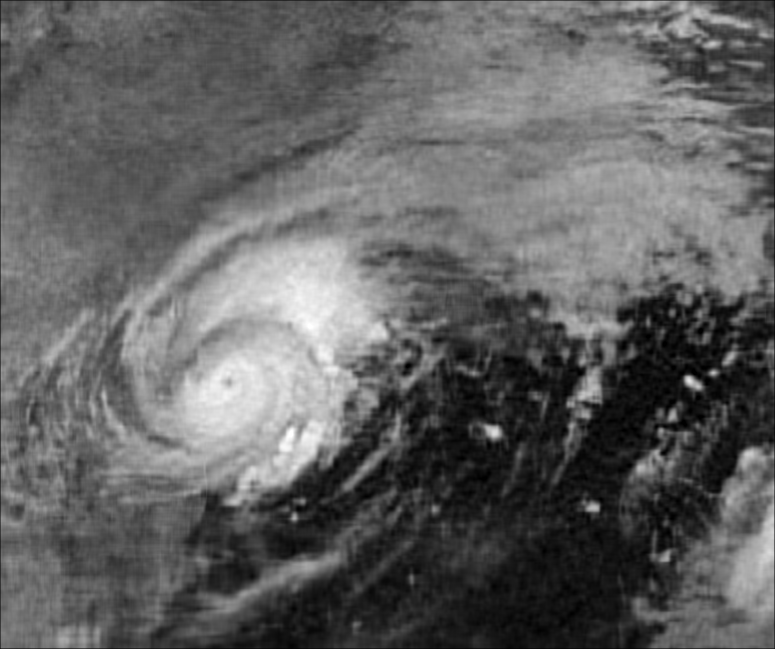

In [104]:
X̃, err = svd_compress(X, 40)
print(err)
Gray.(X̃)

In [92]:
err_list = zeros(50)
U, σ, V = svd(X, full=true);
for (i, k) in enumerate(10 .^ range(0, stop=3, length=50))
    k = Int(floor(k))
    X̃           = zeros(size(X))
    X̃           = sum(σ[i] * U[:, i] * V[:, i]' for i in 1:k)
    err_list[i] = norm(X - X̃)/norm(X)
end

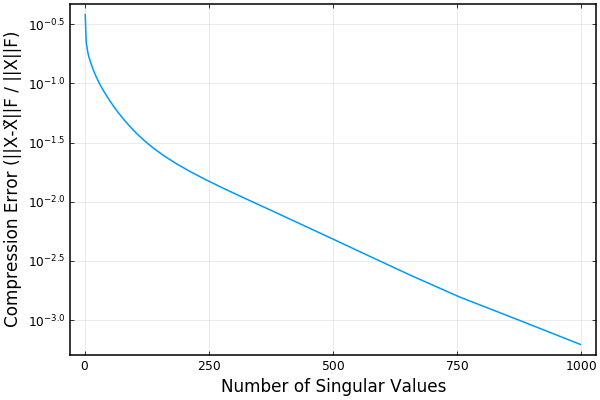

In [99]:
using Plots; pyplot()

plot(Int.(floor.(10 .^ range(0, stop=3, length=50))), err_list, 
        box=:on, thickness_scaling=1.1, yscale=:log10, label=:none,
        xlabel="Number of Singular Values",
        ylabel="Compression Error (||X-X̃||F / ||X||F)")

## Problem 4

In [108]:
using MAT
using Statistics

┌ Info: Precompiling MAT [23992714-dd62-5051-b70f-ba57cb901cac]
└ @ Base loading.jl:1278


In [116]:
vars = matread("mnist_all.mat")

Dict{String,Any} with 20 entries:
  "test7"  => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "train3" => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "test6"  => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "test2"  => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "train7" => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "test3"  => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "test5"  => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "train2" => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "test1"  => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "train9" => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "test9"  => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00…
  "train8" => UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 

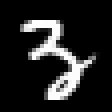

In [130]:
img_as_mat = permutedims(reshape(vars["test3"][9,:], (28, 28)), [2, 1])
Gray.(img_as_mat/255)

In [255]:
function get_dataset(vars, classifier_digit)

    X_train = zeros()
    y_train = zeros()

    X_test  = zeros()
    y_test  = zeros()

    for digit in 0:9

        label = digit == classifier_digit ? 1 : 0

        X_train = digit == 0 ? vars["train$(digit)"] : vcat(X_train, vars["train$(digit)"])
        y_train = digit == 0 ? label*ones(size(vars["train$(digit)"])[1], 1) : vcat(y_train, label*ones(size(vars["train$(digit)"])[1], 1))

        X_test  = digit == 0 ? vars["test$(digit)"]  : vcat(X_test,  vars["test$(digit)"])
        y_test  = digit == 0 ? label*ones(size(vars["test$(digit)"])[1], 1)  : vcat(y_test,  label*ones(size(vars["test$(digit)"])[1], 1))

    end

    X_train = Float64.(X_train)
    y_train = Float64.(y_train)

    X_test  = Float64.(X_test)
    y_test  = Float64.(y_test);
    
    return X_train, y_train, X_test, y_test
    
end

get_dataset (generic function with 1 method)

In [315]:
ws = []
accs = []
attention_maps = []

for digit in 0:9

    X_train, y_train, X_test, y_test = get_dataset(vars, digit)
    
    λ = 1E11
    w = inv(X_train'*X_train + λ*I)*X_train'*y_train
    
    push!(ws, w)
    
    y_pred = X_test * w

    y_pred[y_pred .<  0.5] .= 0
    y_pred[y_pred .>= 0.5] .= 1

    acc = mean(y_pred .== y_test)
    
    push!(accs, acc)
    
    w = abs.(w)
    w = (w .- minimum(w)) / (maximum(w) - minimum(w))
    attention_map = Gray.(permutedims(reshape(w, (28, 28)), [2, 1]))
    
    push!(attention_maps, attention_map)
    
end

accs

10-element Array{Any,1}:
 0.902
 0.8865
 0.8968
 0.899
 0.9018
 0.9108
 0.9042
 0.8972
 0.9026
 0.8991

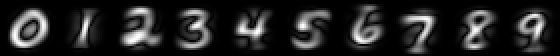

In [316]:
mosaicview(attention_maps..., nrow=1, rowmajor=true)

In [ ]:
#attention_mat = rotl90(reshape(w, (28, 28)))
#heatmap(-attention_mat, c=:Spectral)

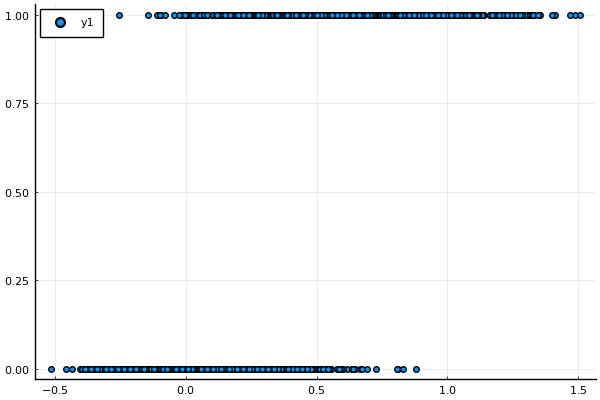

In [189]:
y_pred = X_test * w
scatter(y_pred, y_test)

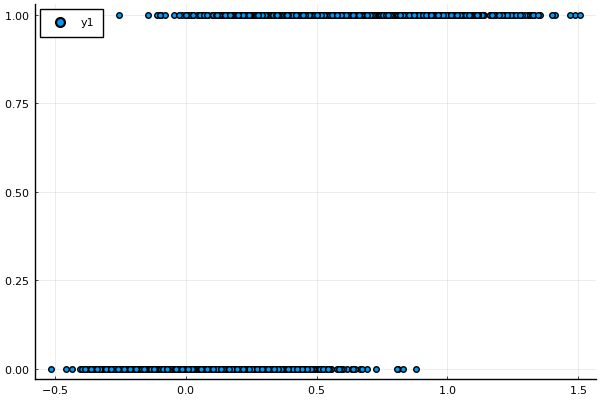

In [191]:
y_pred = X_test * w
scatter(y_pred, y_test)

## Problem 6

In [ ]:
using Distributions

In [ ]:
function rand_matrix_from_row_dist(dist, n, d)
    
    A = zeros(n, d)
    
    for i in 1:n
        A[i, :] = rand(dist)
    end
    
    return A
    
end

In [ ]:
μ = ones(d)
Σ = [2*0.5^abs(i-j) for i in 1:d, j in 1:d]

μt = zeros(d)

GA = MvNormal(μ, Σ)
T1 = MvTDist(1, μt, Σ)
T3 = MvTDist(3, μt, Σ)

A_GA = rand_matrix_from_row_dist(GA, n, d)
A_T3 = rand_matrix_from_row_dist(T3, n, d)
A_T1 = rand_matrix_from_row_dist(T1, n, d);